<a href="https://colab.research.google.com/github/suren777/Ml-AI-in-finance/blob/master/BlackScholesCalibrator_rand_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Black-Scholes calibrator
## Introduction
* This example is created to show the capacity of AI in finance. We want to show that neural network is capable of learning the relationship between option price and implied volatility.

* We will look at a simplified version of so called **"Deep Volatility"** problem. In the nutshell we want to generate implied volatilities from market inputs such as interest rate, spot, maturity, strike and option price. There is no analytical solution to the problem since the relationship is non-linear. Traditional solution would be using numerical methods to calibrate the implied volatility, which can be resource heavy when we need to calibrate multiple implied volatilities.

* We want to show that there is another way.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from scipy.optimize import bisect
import numpy as np
from time import time
import pandas as pd
from scipy.stats import norm
import seaborn as sns
sns.set_context("notebook", font_scale=0.9, rc={"lines.linewidth": 2.5})
sns.set_style('dark')

     |████████████████████████████████| 348.9MB 71kB/s 
     |████████████████████████████████| 3.1MB 29.5MB/s 
     |████████████████████████████████| 501kB 41.3MB/s 


## Define dataset generator
* We first want to create dataset for our problem using randomly generated marked data and BS option pricing formula to generate corresponding option prices. To do so, we will introduce following functions.

* In addition, we will define an implied volatility calibrator using bisection method.

In [0]:
def blackScholesPriceTrue(S0, r, K, T, vol):
    F = S0*np.exp(-r*T)
    Strike = S0*K
    sqt = vol * np.sqrt(T)
    d1 = (np.log(F / Strike) + 0.5 * vol* vol * T)/sqt
    d2 = d1 - sqt
    n1 = norm.cdf(d1)1
    n2 = norm.cdf(d2)
    return n1 - Strike/F * n2

def impliedVol(S0, r, K, T, optPrice):
    def objFunc(vol):
        return blackScholesPriceTrue(S0, r, K, T, vol) - optPrice
    return bisect(objFunc, 0.0001, 1.0, xtol=0.01)


def createDataset(size):
    S0 = np.random.normal(100, 50, size=size)
    r = np.random.uniform(.005,0.02, size)
    K = np.random.uniform(0.8,1.2, size)
    T = np.random.uniform(0.5,1,size)
    vol = np.random.lognormal(-2,0.4, size)
    options = blackScholesPriceTrue(S0, r, K, T, vol)
    columns = "spots,rates,strikes,tenors,optionPrices,vols".split(',')
    data = np.array([S0, r, K, T, options, vol])
    data = pd.DataFrame(data=data.T, columns=columns)
    data = data[data["optionPrices"]>=0.01]
    data = data[data["spots"]>=0.01]
    return data

* Generate sample and see the bottom part of the dataset

In [0]:
sample_size = 500000
data = createDataset(sample_size)
data.tail()

,spots,rates,strikes,tenors,optionPrices,vols
499994,142.521594,0.014056,0.893315,0.646769,0.111399,0.152416
499996,62.698774,0.014801,1.038123,0.795400,0.066310,0.245248
499997,47.195039,0.013657,0.876517,0.879120,0.134404,0.177115
499998,104.088023,0.014231,0.805193,0.759014,0.190884,0.168499
499999,76.292529,0.019127,0.825297,0.505546,0.176433,0.228747


* We will split dataset in training and test sets
* For machine-learning purposes we will need to normalise our inputs.

In [0]:
train_data = data.sample(frac=0.8,random_state=0)
test_data = data.drop(train_data.index)
train_stats = train_data.describe()
train_stats.pop("vols")
train_stats = train_stats.transpose()

train_labels = train_data.pop('vols')
test_labels = test_data.pop('vols')

def normalize(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = normalize(train_data)
normed_test_data = normalize(test_data)

## Neural network
We will setup a neural network using Keras library inside tensorflow module 

In [0]:
h_layers = 256
model=keras.Sequential( [
    layers.Dense(h_layers, activation='tanh', input_shape=[len(train_data.keys())]),
    layers.Dense(h_layers, activation="tanh"),
    layers.Dense(h_layers, activation="tanh"),
    layers.Dense(h_layers, activation="tanh"),
    layers.Dense(h_layers, activation="tanh"),
    layers.Dense(1, activation="elu"),
    layers.Dense(1)])
optimizer = tf.keras.optimizers.RMSprop(0.01)
model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2

Calibration of the neural network

In [0]:
modelFile = 'bsCalibratorModel.hdf5'
epochs = 1000

checkpoint = callbacks.ModelCheckpoint(modelFile, monitor='val_loss')
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
    
history = model.fit(normed_train_data, train_labels,  batch_size=2048,
    epochs=epochs, validation_split = 0.2, verbose=0, shuffle=True,
    callbacks=[PrintDot(), checkpoint, reduce_lr, early_stop])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Prepare outputs.
* In this section we will see how network performed during the training.

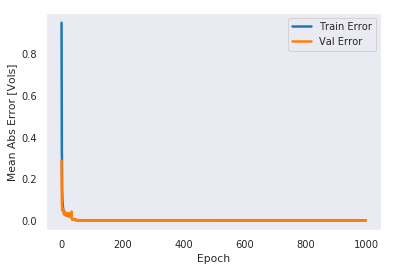

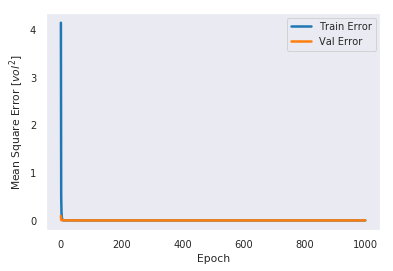

In [0]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Vols]')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label = 'Val Error')
    plt.legend()
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$vol^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label = 'Val Error')
    plt.legend()

  
  
plot_history(history)

## Summary
We will loook how the network performing on the test data.

(0.1, 0.5)

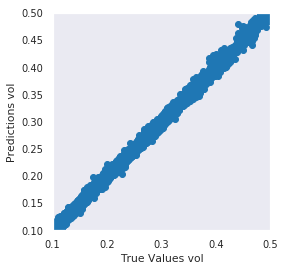

In [0]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values vol')
plt.ylabel('Predictions vol')
plt.axis('equal')
plt.axis('square')
plt.xlim([0.1, 0.5])
plt.ylim([0.1, 0.5])

Text(0.5, 0, 'Prediction Error [vols]')

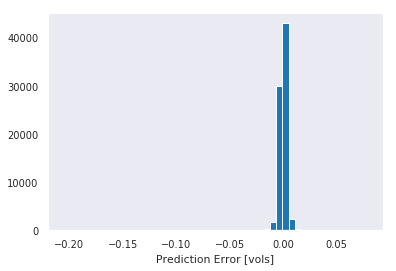

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [vols]")

### Speed Benchmark against classic approach

In [0]:
#Test Speed
ai_speed = time()
ivols_dl = model.predict(normed_test_data).flatten()
ai_speed = time()-ai_speed

bisect_speed = time()
ivols_bs = test_data.apply(lambda x: impliedVol(x["spots"], x["rates"], x["strikes"], x["tenors"], x["optionPrices"]), axis=1)
bisect_speed = time()-bisect_speed

In [0]:
print("Sample size: {0}".format(test_data.shape[0]))
print("ML execution time: {0}".format(ai_speed))
print("Bisection execution time: {0}".format(bisect_speed))
print("Speedup: {0}".format(bisect_speed/ai_speed))

Sample size: 78105
ML execution time: 3.00211238861084
Bisection execution time: 153.91716408729553
Speedup: 51.269620908002466


### Error benchmark against classic approach



Text(0.5, 0, 'Prediction Error [vols]')

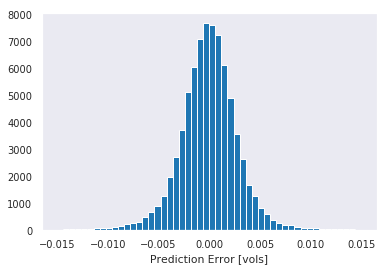

In [0]:
plt.hist(error, bins = 50, range=(-0.015, 0.015))
plt.xlabel("Prediction Error [vols]")

Text(0.5, 0, 'Calibration Error [vols]')

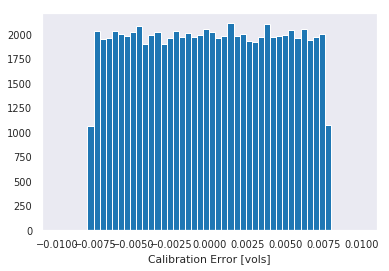

In [0]:
error_bs = ivols_bs-test_labels
plt.hist(error_bs, bins = 50, range=(-0.01, 0.01))
plt.xlabel("Calibration Error [vols]")